In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch 

In [3]:
PATH = os.path.abspath('..')

In [4]:
# get labeled data (excluding test)
label_csv = f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv'

n = len(list(open(label_csv))) - 1 
val_idxs = get_cv_idxs(n)

# see a few
df = pd.read_csv(label_csv, index_col='objID')
df.head()

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,h_beta_flux,h_beta_flux_err,h_delta_flux,h_delta_flux_err,d4000,d4000_err,bptclass,oh_p50,lgm_tot_p50,sfr_tot_p50
objID,,,,,,,,,,,,,,,,,,,,,
1237657070629027993,460656645643462656,42.848838,-0.087291,0.053164,0.000007,47.39425,13.83830,18.62205,0.039646,17.40391,...,77.06317,2.665140,20.252570,2.762302,1.390432,0.016158,1,8.826264,9.676653,0.130842
1237658203440283667,1440030424800716800,193.603250,48.774640,0.045358,0.000014,56.04235,14.63707,17.95715,0.024831,16.78851,...,33.65274,2.762887,13.318680,3.409556,1.437371,0.024805,1,8.870417,9.774070,0.042070
1237657071157117111,784893009903773696,22.873397,0.336578,0.095072,0.000010,59.03400,12.17910,19.92969,0.067595,18.54727,...,28.92639,1.585112,6.887691,1.785967,1.465837,0.019227,1,9.061250,10.154880,-0.180383
1237657071698378865,1209386973525993472,32.793831,0.631794,0.042327,0.000020,71.91644,20.22402,19.61407,0.085397,18.14444,...,14.20437,1.500584,2.976142,2.110726,1.391771,0.034714,1,8.606583,9.523041,-2.125353
1237657118404903062,1193505347646547968,117.996807,29.413908,0.121984,0.000007,0.00000,55.30409,19.11589,0.043633,18.29203,...,79.92870,2.623430,24.953430,2.327975,1.182455,0.016764,1,8.707049,9.862308,0.482178


In [6]:
id_num = 1237657070629027993
os.path.isfile(f'{PATH}/images/{id_num}.jpg')

True

In [7]:
df.columns

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p50', 'lgm_tot_p50',
       'sfr_tot_p50'],
      dtype='object')

### Examine some of the data

In [8]:
image_ids = [os.path.split(fname)[1].strip('.png') for fname in glob(f'{PATH}/images/*.jpg')]
image_ids[:5]

['1237645879551066262.j',
 '1237645879577936138.j',
 '1237645942905438495.j',
 '1237645943976493208.j',
 '1237645943978328116.j']

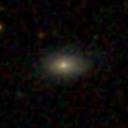

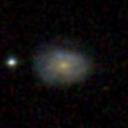

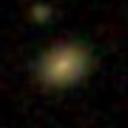

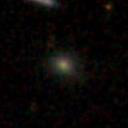

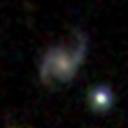

In [9]:
from IPython.display import display
for obj in df.index[:5]:
    display(PIL.Image.open(f'{PATH}/images/{obj}.jpg'))

### Examine distributions of each class

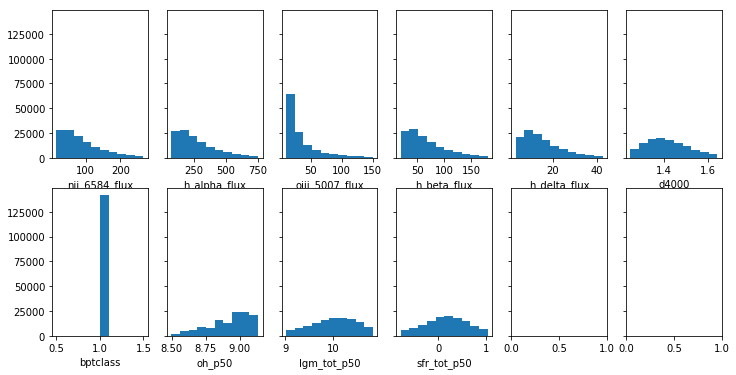

In [10]:
classes = ['nii_6584_flux', 'h_alpha_flux', 'oiii_5007_flux', 'h_beta_flux', 'h_delta_flux', 
           'd4000', 'bptclass', 'oh_p50', 'lgm_tot_p50', 'sfr_tot_p50']

fig, axes = plt.subplots(nrows=2, ncols=len(classes) // 2 + 1, figsize=(12, 6), sharey=True)

for ax, col in zip(axes.flat, classes):
    data = df[col]
    ax.hist(data, range=np.nanpercentile(data, [5, 95]))
    ax.set_xlabel(col)


Let's flag `bptclass` and move on.

## Make a mini training and test sample

I executed the code below to copy a bunch of images to a training set (~10000) and a test set (~5000).

```python
# make a mini training sample of ~15000 images
split_idxs = get_cv_idxs(n, val_pct=20000 / n) 

train_idxs = split_idxs[:-5000]
test_idxs  = split_idxs[-5000:]

# copy files to train-small dir, also make copy of data frame which only has 
# valid images
valid_train_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[train_idxs].index, train_idxs), total=len(train_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/train-small/{objid}.jpg')
        valid_train_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe
df_train_small = df.iloc[valid_train_idxs].copy()
df_train_small.to_csv(f'{PATH}/catalogs/train-small.csv')

# do the same thing, except for test-small dataset
valid_test_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[test_idxs].index, test_idxs), total=len(test_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/test-small/{objid}.jpg')
        valid_test_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe
df_test_small = df.iloc[valid_test_idxs].copy()
df_test_small.to_csv(f'{PATH}/catalogs/test-small.csv')
```

## Adapt the dataloader for using continuous variable output
Here I used some helper functions defined by @farlion from the fast.ai forums.

In [34]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class


In [35]:
fnames, y, idx2class = csv_source_multi_class('train-small', f'{PATH}/catalogs/metallicity-small.csv', '')

In [36]:
@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Train a simple network to predict `oh_p50`

In [77]:
train_label_csv = f'{PATH}/catalogs/metallicity-train-small.csv'
test_label_csv = f'{PATH}/catalogs/metallicity-test-small.csv'

df_train_small[['oh_p50']].to_csv(train_label_csv)
df_test_small[['oh_p50']].to_csv(test_label_csv)

In [38]:
# load in data with transforms
arch = resnet34
sz = 32
bs = 64

In [40]:
val_idxs = get_cv_idxs(len(list(open(train_label_csv))) - 1)

In [43]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train-small', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-small', 
                    num_workers=4, )

In [44]:
data = get_data(sz, bs)

~~It appears that a batch size of `16` pushes my RAM to the limits (maybe even triggering swap space?), but I don't get an out of memory error -- except when lots of apps are open.~~ Now that I'm using categorical morphology, this seems to be going much more quickly and is light on my memory usage.

[8.999]


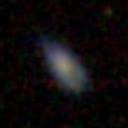

In [45]:
idx = 5 
print(learn.data.trn_y[0])
PIL.Image.open(PATH + '/' + learn.data.trn_ds.fnames[idx])

In [81]:
# initialize network
learn = ConvLearner.pretrained(arch, data)

In [82]:
# find learning rate
lrf=learn.lr_find()

 87%|████████▋ | 133/153 [00:05<00:00, 25.83it/s, loss=19.1]


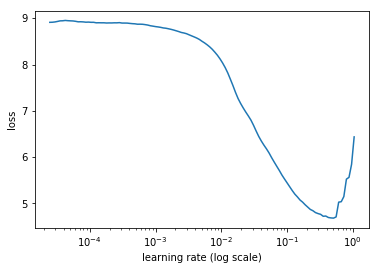

In [83]:
learn.sched.plot()

### Start fitting the los-res images using `rmse` metric
I'm using a learning rate of 0.1.

In [84]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

In [85]:
learn = ConvLearner.pretrained(arch, data)


In [86]:
lr = 0.1
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                               
    0      0.683751   0.129476  
    1      0.199314   0.101916                               
    2      0.119526   0.100124                               



[array([0.10012])]

In [87]:
learn.save(f'{sz}_init-train')

In [88]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                               
    0      0.110067   0.09776   
    1      0.111898   0.107801                               
    2      0.10188    0.095762                               
    3      0.113901   0.102551                               
    4      0.108875   0.100238                               
    5      0.103698   0.095716                               
    6      0.100058   0.094602                                



[array([0.0946])]

Looks like loss still has a little ways to go, but we'll move on. Before training on bigger images, let's unfreeze the earlier layers and train them too.

In [89]:
# differential learning rates
learn.unfreeze()

lrs = np.array([1/9, 1/3, 1]) * lr
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      0.095761   0.083373  
    1      0.099854   0.083775                                
    2      0.084576   0.076118                                
    3      0.099814   0.100012                                
    4      0.098727   0.093987                                
    5      0.085244   0.073958                                
    6      0.07926    0.072798                                



[array([0.0728])]

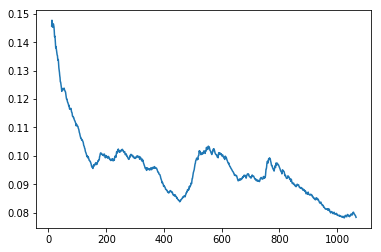

In [90]:
learn.sched.plot_loss()

In [91]:
learn.save(f'{sz}_diff-learn-1')

From the look of it, we're still not overfitting yet. In fact, the training `rmse` is *higher* than the crossval `rmse`... Does that mean that we're nowhere near overfitting? 

In [92]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss                                
    0      0.080272   0.073689  
    1      0.092796   0.075791                                
    2      0.085211   0.080358                                
    3      0.077751   0.072364                                
    4      0.101213   0.076946                                
    5      0.093605   0.075156                                
    6      0.089903   0.074999                                
    7      0.086707   0.12022                                 
    8      0.081999   0.077015                                
    9      0.079687   0.075953                                
    10     0.076664   0.071229                                
    11     0.074598   0.071449                                
    12     0.07278    0.07087                                 



[array([0.07087])]

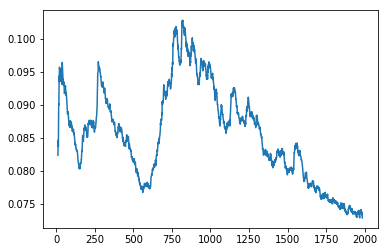

In [93]:
learn.sched.plot_loss()

In [94]:
learn.save(f'{sz}_diff-learn-2')

## Examining predictions using the validation set

In [52]:
learn.load(f'{sz}_diff-learn-2')

In [78]:
learn.set_data(get_data(sz, bs))
pred = learn.predict()

pred.shape

Prediction: 8.780, True: 8.672, error: 0.108


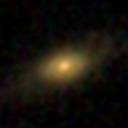

Prediction: 8.903, True: 8.849, error: 0.054


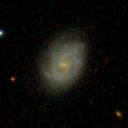

Prediction: 9.076, True: 8.948, error: 0.128


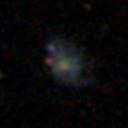

Prediction: 8.976, True: 8.972, error: 0.004


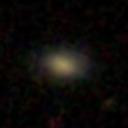

Prediction: 8.883, True: 8.868, error: 0.016


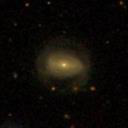

In [95]:
for i in range(5):
    p, p_val = pred[i, 0], learn.data.val_y[i, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, p_val, np.abs(p-p_val)))
    display(PIL.Image.open(PATH + '/' + learn.data.trn_ds.fnames[i]))

### Check test set error distribution

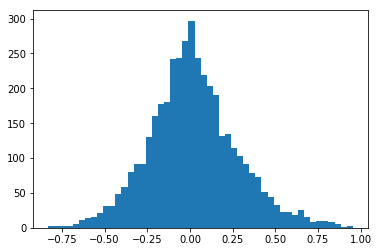

In [97]:
#pred_test = learn.predict(is_test=True)
#y_test = pd.read_csv(test_label_csv).oh_p50

plt.hist((pred_test[:, 0] - y_test), bins=50);

Hm, let's see if we can do better by upgrading the image sizes...

## Continuing using larger image sizes

In [98]:
# doubling up from 32
sz = 64
bs = 64

learn.set_data(get_data(sz, bs))


In [99]:
learn.lr_find()

 88%|████████▊ | 134/153 [00:07<00:01, 18.89it/s, loss=0.618]


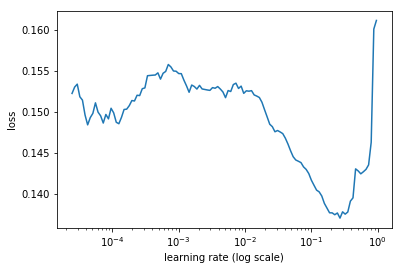

In [100]:
learn.sched.plot()

Stick with 0.1 I guess

In [102]:
lr = 0.1

learn.freeze()
learn.fit(lr, 3)

epoch      trn_loss   val_loss                               
    0      0.124988   0.111054  
    1      0.127541   0.110079                               
    2      0.119074   0.102005                               



[array([0.10201])]

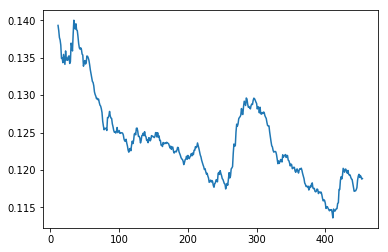

In [103]:
learn.sched.plot_loss()

### Unfreeze early layers again

It looks like training is pretty slow so we'll want to zip things along...

In [104]:
learn.unfreeze()

lrs = np.array([1/9, 1/3, 1]) * lr
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      0.087456   0.075863  
    1      0.087718   0.07536                                 
    2      0.07777    0.071535                                
    3      0.092033   0.092833                                
    4      0.083778   0.070746                                
    5      0.078382   0.068714                                
    6      0.07307    0.068048                                



[array([0.06805])]

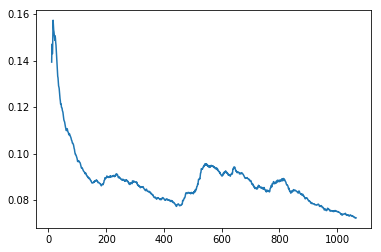

In [105]:
learn.sched.plot_loss()

In [106]:
learn.save(f'32-64_diff-learn-1')

### Train for a really long time

In [ ]:
learn.fit(lrs, n_cycle=5, cycle_len=2, cycle_mult=3)

  6%|▌         | 9/153 [00:01<00:25,  5.76it/s, loss=0.0752]